# Klassifikation mit strukturierten Daten - Halloween

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import warnings

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_log_error, confusion_matrix

### Einlesen und erste Analyse der Daten

In [2]:
train = pd.read_csv("./resources/train.csv")
test = pd.read_csv("./resources/test.csv")
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [3]:
train['color'].unique()

array(['clear', 'green', 'black', 'white', 'blue', 'blood'], dtype=object)

In [4]:
test.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color
0,3,0.471774,0.387937,0.706087,0.698537,black
1,6,0.427332,0.645024,0.565558,0.451462,white
2,9,0.549602,0.491931,0.660387,0.449809,black
3,10,0.638095,0.682867,0.471409,0.356924,white
4,13,0.361762,0.583997,0.377256,0.276364,black


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
id               371 non-null int64
bone_length      371 non-null float64
rotting_flesh    371 non-null float64
hair_length      371 non-null float64
has_soul         371 non-null float64
color            371 non-null object
type             371 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


In [6]:
train.describe()

,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


### Ids sind irrelevant.

In [7]:
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

### Aufteilen der Spalten in numerisch und kategorisch

In [8]:
numerical_vars = ['bone_length', 'rotting_flesh', 'hair_length', 'has_soul']
categorical_vars = ['color']

### Analysiere Korrelationen in den kontinuierlichen Variablen -> Aus den Diagramm wird ersichtlich, dass alle Variablen im Wesentlichen normal verteilt sind.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ED6F006B00>,
      dtype=object)

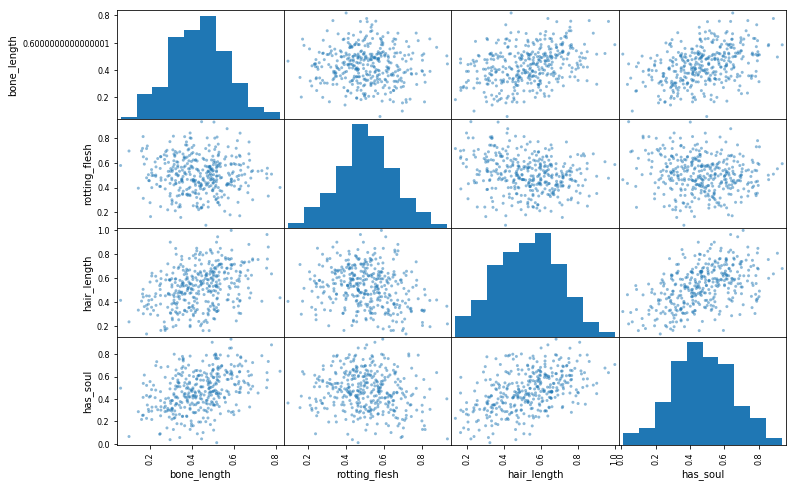

In [9]:
scatter_matrix(train[numerical_vars], figsize=(12,8))

### Transformation der Daten in ein rein numerisches Format

In [10]:
class DataFrameSelector(BaseEstimator, TransformerMixin):

     def __init__(self, attribute_names):
         self.attribute_names = attribute_names

     def fit(self, X, y=None):
         return self

     def transform(self, X):
         return X[self.attribute_names].values

In [12]:
num_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(numerical_vars)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('select_categorical', DataFrameSelector(categorical_vars)),
    ('cat_encoder', OneHotEncoder()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

### Aufteilen in unabhängige (zu bestimmende) und abhängige Variablen (Features)

In [13]:
train_X = train.drop(columns=['type'])
labels_X = train['type']

In [14]:
X_train_prepared = full_pipeline.fit_transform(train_X)

In [15]:
X_train_prepared

<371x10 sparse matrix of type '<class 'numpy.float64'>'
	with 1855 stored elements in Compressed Sparse Row format>

In [16]:
y_train_prepared = labels_X.map({'Ghoul':0, 'Goblin':1, 'Ghost':2})

### Aufteilen der Daten in Test- und Validierungssatz

In [17]:
X_train, X_val, y_train, y_val = \
    train_test_split(X_train_prepared, y_train_prepared.values, test_size=0.1, random_state=42)

### Im nächsten Schritt definieren wir eine Funktionen, mit der wir für verschiedene Modelle die besten Hyperparameterkombinationen herausfinden können. 

In [25]:
def perform_grid_search_for_models(models, param_grids):
    best_models = []
    for i in range(0, len(models)):
        grid_search = GridSearchCV(models[i], param_grids[i], cv=5, scoring='neg_mean_squared_log_error')
        grid_search.fit(X_train, y_train)
        print(str(models[i]).split('Classifier')[0])
        print(grid_search.best_params_)
        best_models.append(grid_search.best_estimator_)
    return best_models

In [26]:
param_grid_forest = [
    {'n_estimators': [35, 40, 45, 50, 55, 60], 'max_depth': [3, 5, 7, 9]}
]

param_grid_ada = [
    {'n_estimators': [35, 40, 45, 50, 55, 60], 'learning_rate': [0.1, 0.3, 0.5, 0.7]}
]

In [27]:
forest = RandomForestClassifier()
ada = AdaBoostClassifier()

In [28]:
models = [forest, ada]
param_grids = [param_grid_forest, param_grid_ada]

In [29]:
best_models = perform_grid_search_for_models(models, param_grids)

C:\Users\trug\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForest
{'max_depth': 9, 'n_estimators': 35}
AdaBoost
{'learning_rate': 0.3, 'n_estimators': 40}


C:\Users\trug\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Nun erzeugen wir eine Funktion, die uns für die jeweils beste Parameterwahl, die Wichtigkeit der verschiedenen Features ermittelt.

In [32]:
def find_feature_importances(best_models):
    for i in range(0, len(best_models)):
        feature_importances = best_models[i].feature_importances_
        all_attributes = categorical_vars + numerical_vars
        print(str(best_models[i]).split('Classifier')[0])
        print(sorted(zip(feature_importances, all_attributes), reverse=True))

In [33]:
find_feature_importances(best_models)

RandomForest
[(0.31555645933585563, 'rotting_flesh'), (0.2661718349792076, 'hair_length'), (0.18583676526196743, 'color'), (0.17873150318808217, 'bone_length'), (0.007980233377891496, 'has_soul')]
AdaBoost
[(0.325, 'rotting_flesh'), (0.325, 'hair_length'), (0.2, 'bone_length'), (0.15, 'color'), (0.0, 'has_soul')]


### Nun möchten wir die gefundenen besten Modelle noch einmal final auf den Trainingsdaten trainieren

In [ ]:
def fit_models(beq)

In [20]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=55, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Wir testen zusätzlich noch den sogenannten AdaBoostClassifier

In [24]:
param_grid_ada = [
    {'n_estimators': [35, 40, 45, 50, 55, 60], 'learning_rate': [0.1, 0.3, 0.5, 0.7]}
]

In [25]:
ada = AdaBoostClassifier()
grid_search_ada = GridSearchCV(ada, param_grid_ada, cv=5, scoring='neg_mean_squared_log_error')
grid_search_ada.fit(X_train, y_train)

grid_search_ada.best_params_

C:\Users\trug\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.3, 'n_estimators': 40}

In [30]:
ada_classifier = grid_search_ada.best_estimator_

feature_importances_ada = ada_classifier.feature_importances_
all_attributes = categorical_vars + numerical_vars
sorted(zip(feature_importances_ada, all_attributes), reverse=True)

[(0.325, 'rotting_flesh'),
 (0.325, 'hair_length'),
 (0.2, 'bone_length'),
 (0.15, 'color'),
 (0.0, 'has_soul')]

In [31]:
ada_classifier.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.3, n_estimators=40, random_state=None)

### Evaluieren der Modelle: Anhand der Ergebnisse wird ersichtlich, dass beide Modelle ähnlich gute Vorhersagen treffen. Der RandomForest overfitted allerdings wesentlich stärker als AdaBoost. Auch wenn man die Modelle noch weiter verbessert, wird man nicht weit über 70 Prozent kommen. Dazu ist der Trainingsdatensatz einfach zu klein.

In [32]:
class ModelEvaluator:

    def evaluate_model(self, model, input, labels, limit):
        predictions = model.predict(input)
        some_predictions = predictions[:limit]
        some_labels = list(labels)[:limit]

        differences = np.array(some_predictions) - np.array(some_labels)
        
        count_incorrectly_correctly_classified = []
        for difference in differences:
            if difference.any() != 0:
                count_incorrectly_correctly_classified.append(difference)
        rmsle = np.sqrt(mean_squared_log_error(list(labels), predictions))
        percentage_correctly_classified = (limit - len(count_incorrectly_correctly_classified)) / limit

        return some_predictions, percentage_correctly_classified, rmsle
    
    def evaluate_models(self, models):
        for model in models:
            predicted_values_validation, percentage_correct_classified_validation, rmsle_validation = self.evaluate_model(model, X_val, y_val, 38)
            print(str(model).split('Classifier')[0] + ': Correctly classified on validation set in percent ' + str(percentage_correct_classified_validation))
            predicted_values_train, percentage_correct_classified_train, rmsle_train = self.evaluate_model(model, X_train, y_train, 38)
            print(str(model).split('Classifier')[0] + ': Correctly classified on training set in percent ' + str(percentage_correct_classified_train))
            print(confusion_matrix(y_val, predicted_values_validation))

In [33]:
model_evaluator = ModelEvaluator()
model_evaluator.evaluate_models([random_forest, ada_classifier])

RandomForest: Correctly classified on validation set in percent 0.6842105263157895
RandomForest: Correctly classified on training set in percent 0.9736842105263158
[[9 2 0]
 [4 8 2]
 [1 3 9]]
AdaBoost: Correctly classified on validation set in percent 0.6842105263157895
AdaBoost: Correctly classified on training set in percent 0.6578947368421053
[[ 7  4  0]
 [ 3 10  1]
 [ 0  4  9]]
